In [1]:
import numpy as np
import pandas as pd

import cv2
import requests
from PIL import Image
from io import BytesIO
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

import os
import glob

import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import sigmoid
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import numpy as np

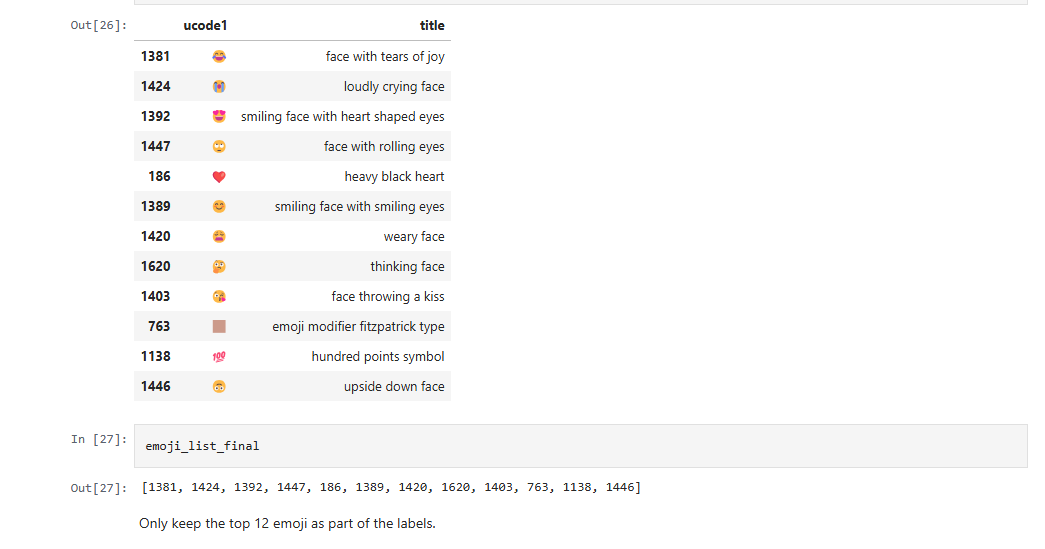

We ignore the emoji modifier, hence we are left with the top11.

In [2]:
top11 = [1381, 1424, 1392, 1447, 186, 1389, 1420, 1620, 1403, 1138, 1446]

ONLY USE ONE OF THE 2 OBJECT CLASSES (1st one is for RGB only, 2nd one is for RGB and edge).

In [46]:
class EmojiDataset(Dataset):
    def __init__(self, rgb_images, transform=None):
        self.rgb_images = rgb_images  # (num, 224, 224, 3)
        self.transform = transform

    def __len__(self):
        return len(self.rgb_images)

    def __getitem__(self, idx):
        # Convert to PyTorch tensors
        rgb = torch.tensor(self.rgb_images[idx], dtype=torch.float32)

        # Permute from (H, W, C) → (C, H, W)
        rgb = rgb.permute(2, 0, 1)  # (3, 224, 224)
        # Normalize image pixels to [0,1]
        rgb /= 255.0

        if self.transform:
            rgb = self.transform(rgb)
        
        return rgb

In [5]:
class EmojiDataset(Dataset):
    def __init__(self, rgb_images, edge_images, transform=None):
        self.rgb_images = rgb_images  # (num, 224, 224, 3)
        self.edge_images = np.expand_dims(edge_images, axis=-1)  # Ensure (num, 224, 224, 1)
        self.transform = transform

    def __len__(self):
        return len(self.rgb_images)

    def __getitem__(self, idx):
        # Convert to PyTorch tensors
        rgb = torch.tensor(self.rgb_images[idx], dtype=torch.float32)
        edge = torch.tensor(self.edge_images[idx], dtype=torch.float32)

        # Permute from (H, W, C) → (C, H, W)
        rgb = rgb.permute(2, 0, 1)  # (3, 224, 224)
        edge = edge.permute(2, 0, 1)  # (1, 224, 224)
        # Concatenate along channel dimension
        combined = torch.cat((rgb, edge), dim=0)  # (4, 224, 224)
        # Normalize image pixels to [0,1]
        combined /= 255.0

        if self.transform:
            combined = self.transform(combined)
        
        return combined

The following template uses rgb only.

In [47]:
### Code to load the image 
IMG_SIZE = (224, 224)

# Open the image from the content using PIL
img = Image.open("sample.jpg")

# discovered that some images have an alpha (transparency) channel
if img.mode == "RGBA":
    img = img.convert("RGB")  # Convert RGBA → RGB
    
# Convert rgb image to numpy array
rgb_arr = np.array(img)

# Some images are grayscale by default
if len(rgb_arr.shape) == 2:  # Grayscale image
    rgb_arr = np.stack((rgb_arr,)*3, axis=-1)  # Convert (H,W) → (H,W,3)
    
rgb_arr = cv2.resize(rgb_arr, IMG_SIZE, interpolation=cv2.INTER_CUBIC) # upscale/interpolate for smaller images

# Convert the RGB image to Grayscale (Luminance)
grayscale_img = img.convert('L')
grayscale_arr = np.array(grayscale_img)
# Apply Edge Detection using OpenCV (Canny Edge Detection)
edge_arr = cv2.Canny(grayscale_arr, 100, 200)  # can adjust thresholds (100, 200)
edge_arr = cv2.resize(edge_arr, IMG_SIZE, interpolation=cv2.INTER_CUBIC) # interpolate for smaller images

rgb_list = []
rgb_list.append(rgb_arr)
rgb = np.array(rgb_list)  # Convert list to numpy array

edge_list = []
edge_list.append(edge_arr)
edge = np.array(edge_list)  # Convert list to numpy array

sample_dataset = EmojiDataset(rgb, transform=None)
sample_loader = DataLoader(sample_dataset, batch_size=1, shuffle=False)

print(rgb.shape)
print(edge.shape)

(1, 224, 224, 3)
(1, 224, 224)


In [48]:
rgb = sample_dataset[0]

print("Single image shape:", rgb.shape)  # Expected: (4, 224, 224)

Single image shape: torch.Size([3, 224, 224])


In [49]:
for rgb in sample_loader:
    print("Batch image shape:", rgb.shape)  # Expected: (1, 4, 224, 224)
    break

Batch image shape: torch.Size([1, 3, 224, 224])


Replace the model name.

In [50]:
model = torch.load("resnet18.pth",  weights_only=True)
model.eval()

for threshold in (0.3, 0.5, 0.7):
    print(f"Threshold: {threshold}")
    
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for rgb in sample_loader:

            outputs = model(rgb)
            # Convert logits to probabilities
            probs = sigmoid(outputs)  
            # Convert logits to binary, 
            # Threshold at 0.5 (adjustable) to get binary labels
            predicted = (probs > threshold).float()
            
print(predicted)

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torchvision.models.resnet.ResNet was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torchvision.models.resnet.ResNet])` or the `torch.serialization.safe_globals([torchvision.models.resnet.ResNet])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.